# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
!pip install kneed
from kneed import KneeLocator
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from sklearn.metrics import davies_bouldin_score, silhouette_score
import scipy.cluster.hierarchy as sch

## Data Preparation

The dataset that we will use on this project is Customer Analysis Dataset. Below are the columns with the descriptions of each column

People
- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if the customer complained in the last 2 years, 0 otherwise

Products
- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years
Promotion

- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

Place
- NumWebPurchases: Number of purchases made through the company’s website
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s website in the last month

In [ ]:
# load dataset and show the first five sample
df = pd.read_excel("https://github.com/feliciastevany/DataMining-Datasets/raw/refs/heads/main/customer_analysis.xlsx")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


Check unique values for education and marital_status column

In [ ]:
print('Education:', df['Education'].unique())
print('Marital_Status:', df['Marital_Status'].unique())

Education: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


Since in education and marital_status column there are too much unique values, we need to change the values

In [ ]:
# Refined mapping for 'Education' and 'Marital_Status'
education_mapping = {
    'Graduation': 'Graduated',
    'PhD': 'PhD',
    'Master': 'Postgraduate',
    'Basic': 'NonGraduate',
    '2n Cycle': 'NonGraduate'
}

marital_status_mapping = {
    'Single': 'Single',
    'Together': 'In a Relationship',
    'Married': 'In a Relationship',
    'Divorced': 'Separated',
    'Widow': 'Separated',
    'Alone': 'Single',
    'Absurd': 'Other',
    'YOLO': 'Other'
}

df['Education'] = df['Education'].map(education_mapping)
df['Marital_Status'] = df['Marital_Status'].map(marital_status_mapping)

Recheck unique values for education and marital_status column

In [ ]:
print('Education:', df['Education'].unique())
print('Marital_Status:', df['Marital_Status'].unique())

Education: ['Graduated' 'PhD' 'Postgraduate' 'NonGraduate']
Marital_Status: ['Single' 'In a Relationship' 'Separated' 'Other']


Change the Year_Birth column to Age column and convert the Dt_Customer to numeric

In [ ]:
df['Year_Birth'] = 2024 - df['Year_Birth']
df.rename(columns={'Year_Birth': 'Age'}, inplace=True)

# Categorize the customer base on their loyalty (0 = new (<1 year), 1 = mid (1-3 years), 3 = old (>3 years)
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
today = pd.to_datetime("today")
df['Total_days'] = (today - df['Dt_Customer']).dt.days
def categorized_customer(days):
    if days < 365:
        return 0
    elif 365 <= days <= 1095:
        return 1
    elif days > 1095:
        return 2
df['Dt_Customer'] = df['Total_days'].apply(categorized_customer)
df.rename(columns={'Dt_Customer': 'Loyalty_Customer'}, inplace=True)
df = df.drop(columns=['Total_days'])

# Tampilkan hasil
df.head()

,ID,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Loyalty_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,67,Graduated,Single,58138.0,0,0,2,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,70,Graduated,Single,46344.0,1,1,2,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,59,Graduated,In a Relationship,71613.0,0,0,2,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,40,Graduated,In a Relationship,26646.0,1,0,2,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,43,PhD,In a Relationship,58293.0,1,0,2,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


Check if there are any missing values in the data.

In [ ]:
# Check for null values in the dataset
missing_values = df.isnull().sum()
missing_values

# As shown, mostly there are no missing values on the columns. However, there are 24 missing values on income columns.

,0
ID,0
Age,0
Education,0
Marital_Status,0
Income,24
Kidhome,0
Teenhome,0
Loyalty_Customer,0
Recency,0
MntWines,0


# Data Cleaning

Since the missing values are not that much, we fill the missing values using income mean

In [ ]:
# Fill the missing values
df['Income'].fillna(df['Income'].mean(), inplace=True)

<ipython-input-2724-4cbd3bc1a1a5>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].mean(), inplace=True)


Drop the unnecessary column

In [ ]:
# Drop non-relevant columns
columns_to_drop = ['ID', 'Z_CostContact', 'Z_Revenue']
df = df.drop(columns=columns_to_drop)

df.head()

,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Loyalty_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,67,Graduated,Single,58138.0,0,0,2,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,70,Graduated,Single,46344.0,1,1,2,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,59,Graduated,In a Relationship,71613.0,0,0,2,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,40,Graduated,In a Relationship,26646.0,1,0,2,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,43,PhD,In a Relationship,58293.0,1,0,2,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


# Exploratory Data Analysis (EDA)

In [ ]:
# describe data
df.describe()

,Age,Income,Kidhome,Teenhome,Loyalty_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,55.194196,52247.251354,0.444196,0.506250,2.0,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,0.149107
std,11.984069,25037.797168,0.538398,0.544538,0.0,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.356274
min,28.000000,1730.000000,0.000000,0.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,35538.750000,0.000000,0.000000,2.0,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,51741.500000,0.000000,0.000000,2.0,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,65.000000,68289.750000,1.000000,1.000000,2.0,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131.000000,666666.000000,2.000000,2.000000,2.0,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Showing the columns information including datatype of each column

In [ ]:
# Dataset info
df.info()

# As shown, the datatype for all the columns is mostly a number (with only 1 float column). There are only 3 object columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2240 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Loyalty_Customer     2240 non-null   int64  
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

Change the income datatype to int

In [ ]:
df['Income'] = df['Income'].astype(int)

Make sure if all missing values are filled

In [ ]:
missing_values = df.isnull().sum()
missing_values

,0
Age,0
Education,0
Marital_Status,0
Income,0
Kidhome,0
Teenhome,0
Loyalty_Customer,0
Recency,0
MntWines,0
MntFruits,0


Data Visualization

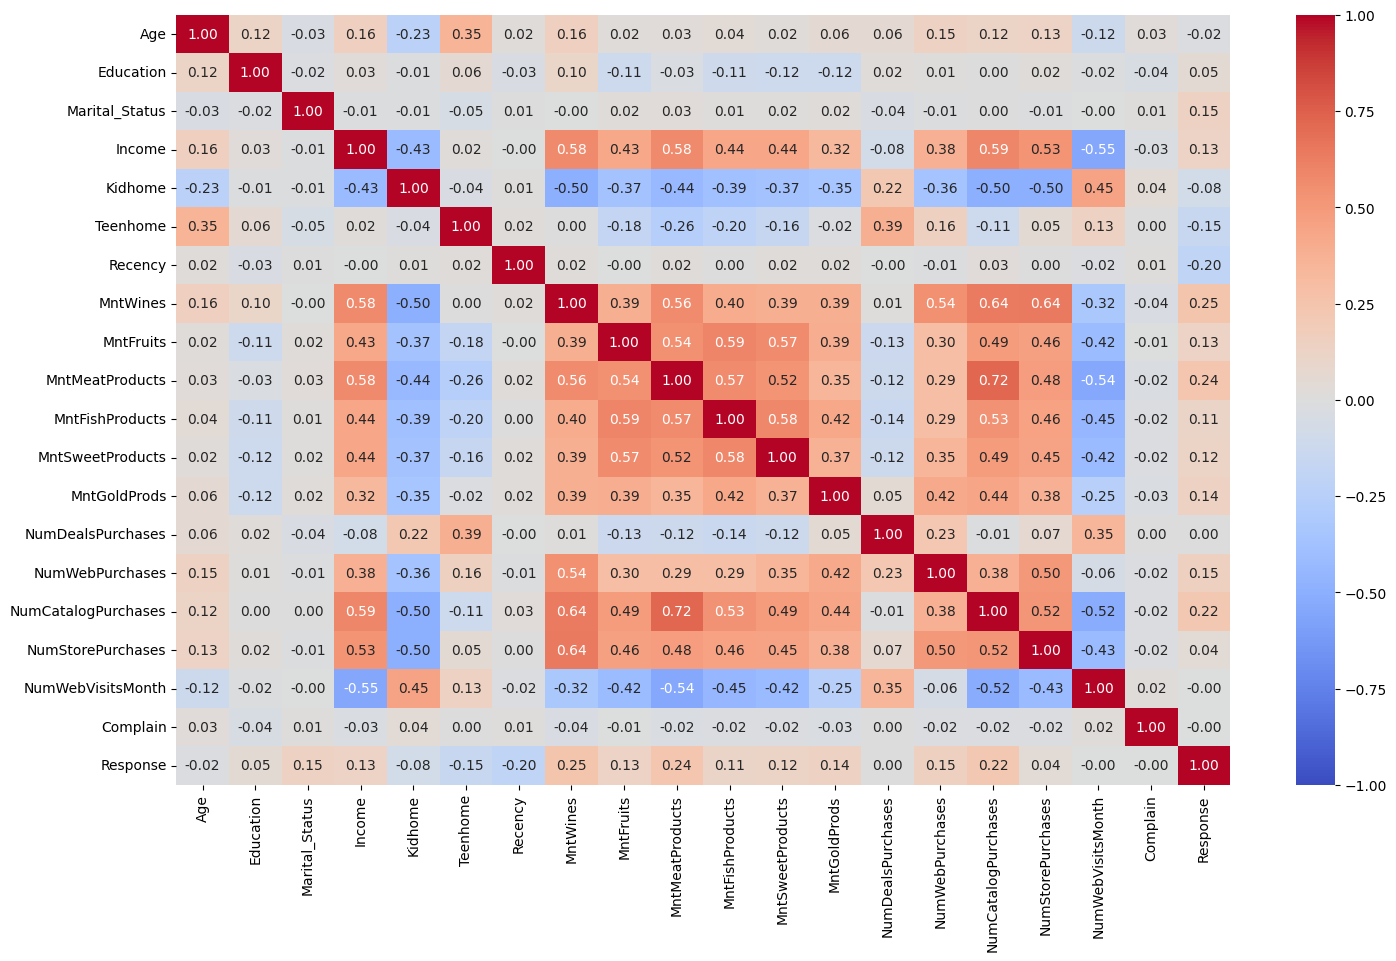

In [ ]:
columns_heat = ['Age', 'Education',	'Marital_Status', 'Income',	'Kidhome', 'Teenhome', 'Recency',	'MntWines',	'MntFruits',
                'MntMeatProducts',	'MntFishProducts',	'MntSweetProducts',	'MntGoldProds',	'NumDealsPurchases',	'NumWebPurchases',
                'NumCatalogPurchases', 'NumStorePurchases',	'NumWebVisitsMonth', 'Complain', 'Response']

corr_matrix = df[columns_heat].corr()

plt.figure(figsize=(17, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('')
plt.show() #Showing the heatmap result

# The heatmap represents a correlation matrix, highlighting the relationships between various numerical features in the dataset. Strong positive correlations (red) are evident
# between features like MntWine and MntGoldProds, indicating that customers who spend more on wine also tend to purchase gold products, while Income shows a negative correlation
# (blue) with NumWebVisitsMonth, suggesting that higher-income customers visit the website less frequently. Weak or no correlations (gray) are observed for features such as
# Complain and Recency, indicating their independence from most other features.

# Data Transformation

Perform label encoding

In [ ]:
encoder = LabelEncoder() # create a LabelEncoder to encode the categorical columns

# apply label encoding to the column
df['Education'] = encoder.fit_transform(df['Education'])
df['Marital_Status'] = encoder.fit_transform(df['Marital_Status'])

df.head(5) # showing 5 head encoded columns

,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Loyalty_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,67,0,3,58138,0,0,2,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,70,0,3,46344,1,1,2,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,59,0,0,71613,0,0,2,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,40,0,0,26646,1,0,2,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,43,2,0,58293,1,0,2,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


Check the datatype of each column after encoding the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Age                  2240 non-null   int64
 1   Education            2240 non-null   int64
 2   Marital_Status       2240 non-null   int64
 3   Income               2240 non-null   int64
 4   Kidhome              2240 non-null   int64
 5   Teenhome             2240 non-null   int64
 6   Loyalty_Customer     2240 non-null   int64
 7   Recency              2240 non-null   int64
 8   MntWines             2240 non-null   int64
 9   MntFruits            2240 non-null   int64
 10  MntMeatProducts      2240 non-null   int64
 11  MntFishProducts      2240 non-null   int64
 12  MntSweetProducts     2240 non-null   int64
 13  MntGoldProds         2240 non-null   int64
 14  NumDealsPurchases    2240 non-null   int64
 15  NumWebPurchases      2240 non-null   int64
 16  NumCatalogPurchases  224

Apply feature scaling to the data

In [ ]:
# scaling data

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_scaled.head(5)

,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Loyalty_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,0.985345,-0.889250,1.620949,0.235327,-0.825218,-0.929894,0.0,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.510890,-0.550785,0.693904,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,2.388846
1,1.235733,-0.889250,1.620949,-0.235826,1.032559,0.906934,0.0,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,-0.418612
2,0.317643,-0.889250,-0.722088,0.773633,-0.825218,-0.929894,0.0,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,-0.226541,1.295237,-0.542647,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,-0.418612
3,-1.268149,-0.889250,-0.722088,-1.022732,1.032559,-0.929894,0.0,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,-0.910898,-0.550785,0.281720,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,-0.418612
4,-1.017761,0.813973,-0.722088,0.241519,1.032559,-0.929894,0.0,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,0.115638,0.064556,-0.130463,-0.28014,-0.28383,-0.28014,-0.262111,-0.11651,-0.097282,-0.418612


## K-Means Clustering

1. Using elbow method

In this case study, determine the number of clusters to be formed. Below parameter settings is used:
- init: random
- range: (1,11)
- max_iter: 300
- random state: 42

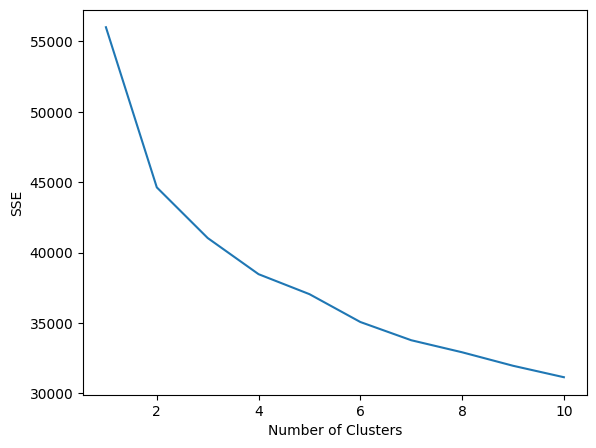

In [ ]:
# Initialize a list to store the WCSS values
wcss = []

# Compute KMeans for k values in range(1, 11)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init="random", max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(6.5, 5))
plt.plot(range(1, 11), wcss, linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
# To find the best clusters for the model
kneedle = KneeLocator(range(1,11), wcss, curve="convex", direction="decreasing")
best_k = kneedle.elbow

print(f"The best k for you model is {best_k}")

The best k for you model is 3


Train the K-Means model on the dataset with the number of clusters you have determined.

In [ ]:
# Apply K-Means with the best number of clusters (based on the result above = 3)
kmeans = KMeans(n_clusters = best_k, init='random', max_iter = 300, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(df_scaled)
y_pred

array([0, 1, 2, ..., 2, 2, 1], dtype=int32)

### K-Means Visualization

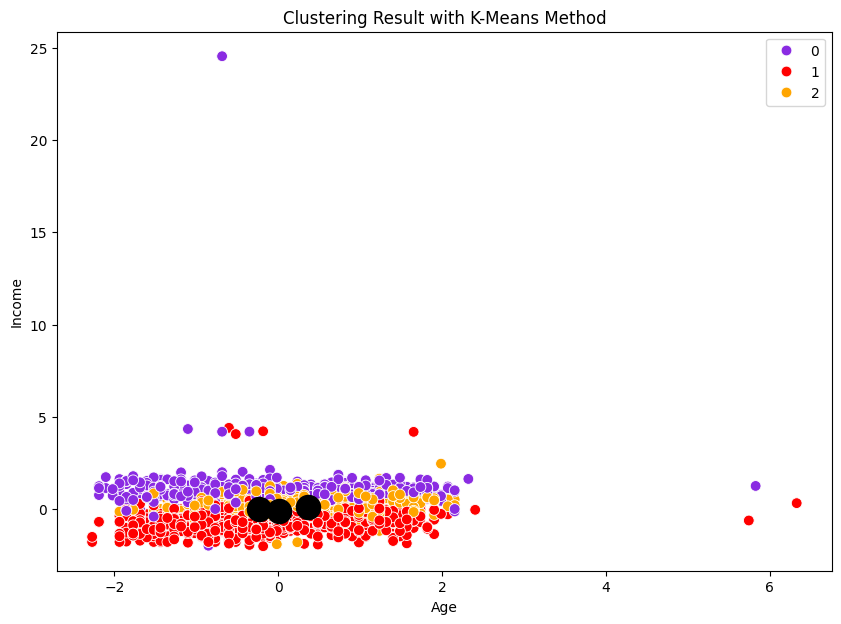

In [ ]:
# visualize the result using scatter chart
plt.figure(figsize = (10, 7))

sns.scatterplot(x = "Age", y = "Income", hue = y_pred, palette = ["blueviolet", "red", "orange"],
                data = df_scaled, s = 60)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = "black")
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Clustering Result with K-Means Method')
plt.show()

Inverse transform the scaled data to get the original values

In [ ]:
df_scaled= pd.DataFrame(scaler.inverse_transform(df_scaled), columns=df_scaled.columns)
df['KMeans'] = y_pred

df.head(5)

,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Loyalty_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,KMeans
0,67,0,3,58138,0,0,2,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,0
1,70,0,3,46344,1,1,2,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,1
2,59,0,0,71613,0,0,2,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,2
3,40,0,0,26646,1,0,2,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,1
4,43,2,0,58293,1,0,2,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,1


Display the cluster summary

In [ ]:
# Group the data by cluster and calculate the mean spending and annual income for each cluster
cluster_summary = df.groupby('KMeans').agg({
    'Age': ['mean', 'std', 'min', 'max'],
    'Education': [pd.Series.mode, 'min', 'max'],
    'Marital_Status': [pd.Series.mode, 'min', 'max'],
    'Income': ['mean', 'std', 'min', 'max'],
    'Kidhome': [pd.Series.mode, 'min', 'max'],
    'Teenhome': [pd.Series.mode, 'min', 'max'],
    'Recency': ['mean', 'std', 'min', 'max'],
    'MntWines': ['mean', 'std', 'min', 'max'],
    'MntFruits': ['mean', 'std', 'min', 'max'],
    'MntMeatProducts': ['mean', 'std', 'min', 'max'],
    'MntFishProducts': ['mean', 'std', 'min', 'max'],
    'MntSweetProducts': ['mean', 'std', 'min', 'max'],
    'MntGoldProds': ['mean', 'std', 'min', 'max'],
    'NumDealsPurchases': ['mean', 'std', 'min', 'max'],
    'NumWebPurchases': ['mean', 'std', 'min', 'max'],
    'NumCatalogPurchases': ['mean', 'std', 'min', 'max'],
    'NumStorePurchases': ['mean', 'std', 'min', 'max'],
    'NumWebVisitsMonth': ['mean', 'std', 'min', 'max'],
    'AcceptedCmp3': [pd.Series.mode],
    'AcceptedCmp4': [pd.Series.mode],
    'AcceptedCmp5': [pd.Series.mode],
    'AcceptedCmp1': [pd.Series.mode],
    'AcceptedCmp2': [pd.Series.mode],
    'Complain': [pd.Series.mode],
    'Response': [pd.Series.mode]
})

cluster_summary = cluster_summary.rename_axis("Cluster")
transpose_cluster_summary = cluster_summary.T

new_columns = [f"Cluster {col}" for col in transpose_cluster_summary.columns]
transpose_cluster_summary.columns = pd.Index(new_columns, name="KMeans")

# Show all the columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

transpose_cluster_summary

KMeans                        Cluster 0      Cluster 1      Cluster 2
Age                 mean      55.290146      52.451336      59.576087
                    std       13.635827      11.378590       9.979861
                    min       29.000000      28.000000      32.000000
                    max      125.000000     131.000000      81.000000
Education           mode       0.000000       0.000000       0.000000
                    min        0.000000       0.000000       0.000000
                    max        3.000000       3.000000       3.000000
Marital_Status      mode       0.000000       0.000000       0.000000
                    min        0.000000       0.000000       0.000000
                    max        3.000000       3.000000       3.000000
Income              mean   77691.045620   35090.882634   58515.371118
                    std    27874.050614   14285.490004   10900.701386
                    min     2447.000000    1730.000000    4428.000000
                    max   666666.000000  162397.000000  113734.000000
Kidhome             mode       0.000000       1.000000       0.000000
                    min        0.000000       0.000000       0.000000
                    max        1.000000       2.000000       2.000000
Teenhome            mode       0.000000       0.000000       1.000000
                    min        0.000000       0.000000       0.000000
                    max        2.000000       2.000000       2.000000
Recency             mean      49.531022      49.532443      48.062112
                    std       29.531951      29.057577      28.329584
                    min        0.000000       0.000000       0.000000
                    max       99.000000      99.000000      99.000000
MntWines            mean     613.844891      42.965649     464.908385
                    std      324.325744      52.988698     285.749642
                    min        1.000000       0.000000       5.000000
                    max     1493.000000     308.000000    1459.000000
MntFruits           mean      68.833942       5.018130      24.746894
                    std       51.359469       7.820738      29.705704
                    min        0.000000       0.000000       0.000000
                    max      197.000000      64.000000     199.000000
MntMeatProducts     mean     471.058394      23.716603     141.262422
                    std      251.187156      25.823122      98.626356
                    min       18.000000       0.000000       3.000000
                    max     1725.000000     206.000000     650.000000
MntFishProducts     mean     100.950730       7.317748      32.712733
                    std       66.258864      12.142783      38.445086
                    min        0.000000       0.000000       0.000000
                    max      259.000000     150.000000     234.000000
MntSweetProducts    mean      70.678832       5.016221      25.826087
                    std       51.801856       7.310727      33.896249
                    min        0.000000       0.000000       0.000000
                    max      198.000000      78.000000     263.000000
MntGoldProds        mean      77.454380      15.436069      62.091615
                    std       60.424729      19.452431      56.060171
                    min        0.000000       0.000000       0.000000
                    max      249.000000     262.000000     362.000000
NumDealsPurchases   mean       1.248175       2.099237       3.608696
                    std        1.246749       1.464538       2.337533
                    min        0.000000       0.000000       0.000000
                    max       15.000000      15.000000      15.000000
NumWebPurchases     mean       5.047445       2.146947       6.419255
                    std        2.141591       1.349721       2.765822
                    min        0.000000       0.000000       1.000000
                    max       11.000000       9.000000      27.000000
NumCatalog

Check the number of values in KMeans column

In [ ]:
df['KMeans'].value_counts().sort_index()

,count
KMeans,
0,548
1,1048
2,644


Interpretation of K-Means Clusters

In [ ]:
# Cluster 0 represents high-income, high-spending individuals who prefer catalog and online shopping for premium products.
# Cluster 1 reflects budget-conscious individuals with limited spending and a focus on deals and frequent web visits.
# Cluster 2 highlights moderate-income individuals with balanced spending and varied shopping channels.

# These clusters can guide targeted marketing strategies, such as offering premium products to Cluster 0, budget-friendly promotions to Cluster 1, and personalized options to Cluster 2.

# Hierarchical Clustering
Hierarchical clustering uses the agglomerative method.

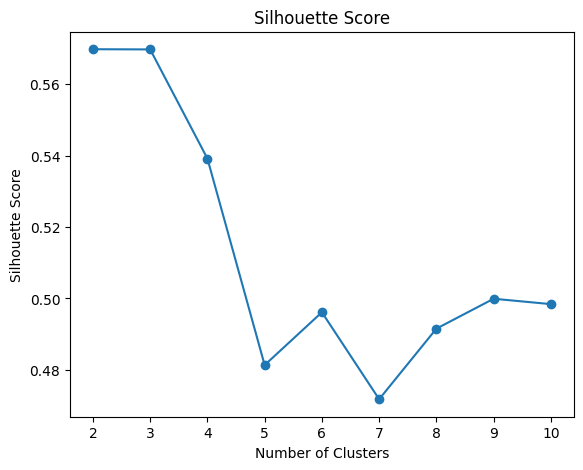

Silhouette Score: 0.498415120254017


In [ ]:
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    clustering_model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = clustering_model.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(6.5, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()
print("Silhouette Score:", silhouette_avg)

Perform hierarchical clustering with the Euclidean distance metric and set the number of clusters based on silhouette score.

In [ ]:
# agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
y_predA = agglomerative.fit_predict(df_scaled)

In [ ]:
# Add the cluster labels to the original data that you have been added with kmeans so you have a full dataframe include kmeans and agglo clustering
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)
df['Agglo'] = y_predA

# show the df
df.head(5)

,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Loyalty_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,KMeans,Agglo
0,67,0,3,58138,0,0,2,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,0,0
1,70,0,3,46344,1,1,2,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,1,0
2,59,0,0,71613,0,0,2,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,2,1
3,40,0,0,26646,1,0,2,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,1,0
4,43,2,0,58293,1,0,2,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,1,0


Display the cluster summary in the form of a dataframe.

In [ ]:
cluster_summary = df.groupby(y_predA).agg({
    'Age': ['mean', 'std', 'min', 'max'],
    'Education': [pd.Series.mode, 'min', 'max'],
    'Marital_Status': [pd.Series.mode, 'min', 'max'],
    'Income': ['mean', 'std', 'min', 'max'],
    'Kidhome': [pd.Series.mode, 'min', 'max'],
    'Teenhome': [pd.Series.mode, 'min', 'max'],
    'Recency': ['mean', 'std', 'min', 'max'],
    'MntWines': ['mean', 'std', 'min', 'max'],
    'MntFruits': ['mean', 'std', 'min', 'max'],
    'MntMeatProducts': ['mean', 'std', 'min', 'max'],
    'MntFishProducts': ['mean', 'std', 'min', 'max'],
    'MntSweetProducts': ['mean', 'std', 'min', 'max'],
})

cluster_summary = cluster_summary.rename_axis("Agglo")
cluster_summary

Age                     Education         Marital_Status          \
            mean        std min  max      mode min max           mode min max   
Agglo                                                                           
0      54.141457  11.509584  28  131         0   0   3              0   0   3   
1      57.057953  12.573649  29  125         0   0   3              0   0   3   
2      47.000000        NaN  47   47         0   0   0              0   0   0   

              Income                               Kidhome         Teenhome  \
                mean           std     min     max    mode min max     mode   
Agglo                                                                         
0       39006.821429  13273.906893    1730   61064       1   0   2        1   
1       74803.242910  11743.698306   60896  162397       0   0   2        0   
2      666666.000000           NaN  666666  666666       1   1   1        0   

                 Recency                       MntWines                        \
      min max       mean        std min max        mean         std min   max   
Agglo                                                                           
0       0   2  49.156863  28.831201   0  99  134.267507  197.895543   0  1241   
1       0   2  49.057953  29.213186   0  99  603.049322  322.095987   1  1493   
2       0   0  23.000000        NaN  23  23    9.000000         NaN   9     9   

       MntFruits                     MntMeatProducts                        \
            mean        std min  max            mean         std min   max   
Agglo                                                                        
0      10.203081  20.672965   0  199       53.339636   91.700857   0  1725   
1      54.664612  48.552133   0  197      367.177559  251.179662   1  1725   
2      14.000000        NaN  14   14       18.000000         NaN  18    18   

      MntFishProducts                     MntSweetProducts                      
                 mean        std min  max             mean        std min  max  
Agglo                                                                           
0           14.986695  29.211895   0  259        10.350140  21.386210   0  263  
1           77.247842  65.341035   0  258        56.522811  50.422515   0  262  
2            8.000000        NaN   8    8         1.000000        NaN   1    1

In [ ]:
cluster_summary = df.groupby(y_predA).agg({
    'MntGoldProds': ['mean', 'std', 'min', 'max'],
    'NumDealsPurchases': ['mean', 'std', 'min', 'max'],
    'NumWebPurchases': ['mean', 'std', 'min', 'max'],
    'NumCatalogPurchases': ['mean', 'std', 'min', 'max'],
    'NumStorePurchases': ['mean', 'std', 'min', 'max'],
    'NumWebVisitsMonth': ['mean', 'std', 'min', 'max'],
    'AcceptedCmp3': [pd.Series.mode],
    'AcceptedCmp4': [pd.Series.mode],
    'AcceptedCmp5': [pd.Series.mode],
    'AcceptedCmp1': [pd.Series.mode],
    'AcceptedCmp2': [pd.Series.mode],
    'Complain': [pd.Series.mode],
    'Response': [pd.Series.mode]
})

cluster_summary = cluster_summary.rename_axis("Agglo")
cluster_summary

MntGoldProds                     NumDealsPurchases                    \
              mean        std min  max              mean       std min max   
Agglo                                                                        
0        29.091036  40.707256   0  362          2.629552  1.989643   0  15   
1        70.351418  59.286528   0  249          1.786683  1.699708   0  15   
2        12.000000        NaN  12   12          4.000000       NaN   4   4   

      NumWebPurchases                  NumCatalogPurchases                    \
                 mean      std min max                mean       std min max   
Agglo                                                                          
0            3.291317  2.63644   0  27            1.223389  1.781266   0  28   
1            5.483354  2.45516   0  27            5.197287  2.818027   0  28   
2            3.000000      NaN   3   3            1.000000       NaN   1   1   

      NumStorePurchases                   NumWebVisitsMonth                    \
                   mean       std min max              mean       std min max   
Agglo                                                                           
0              4.331933  2.421676   0  13          6.405462  1.925784   0  20   
1              8.361282  2.916353   0  13          3.398274  1.992070   0   9   
2              3.000000       NaN   3   3          6.000000       NaN   6   6   

      AcceptedCmp3 AcceptedCmp4 AcceptedCmp5 AcceptedCmp1 AcceptedCmp2  \
              mode         mode         mode         mode         mode   
Agglo                                                                    
0                0            0            0            0            0   
1                0            0            0            0            0   
2                0            0            0            0            0   

      Complain Response  
          mode     mode  
Agglo                    
0            0        0  
1            0        0  
2            0        0

In [ ]:
agglo_counts = df['Agglo'].value_counts().sort_index()
agglo_counts

,count
Agglo,
0,1428
1,811
2,1


Interpretation of Agglomerative Clustering

In [ ]:
# Cluster 0 includes lower-income customers with minimal spending, preferring online browsing but limited engagement across channels.
# Cluster 1 represents high-income, older individuals who are frequent and balanced shoppers, spending significantly across categories.
# Cluster 2 is likely an outlier with extreme income, which doesn't correlate with their spending patterns.

# The segmentation can guide personalized marketing to focus on discounts, deals, or entry-level products for cluster 0, promote premium products and loyalty programs for cluster 1.

### Hierarchical Visualization

Single Linkage

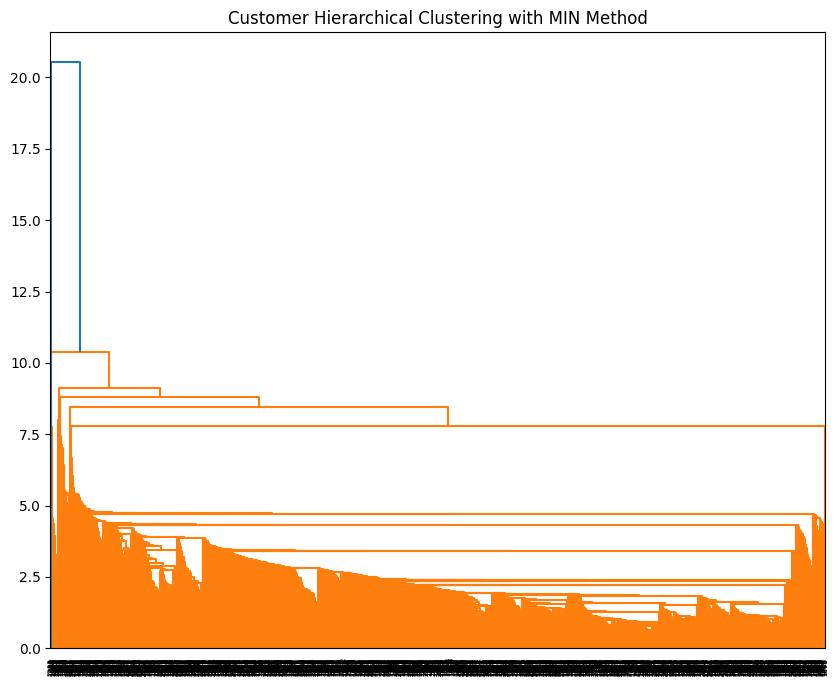

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Customer Hierarchical Clustering with MIN Method")
dend = sch.dendrogram(sch.linkage(df_scaled, method='single'))
plt.show()

Complete linkage

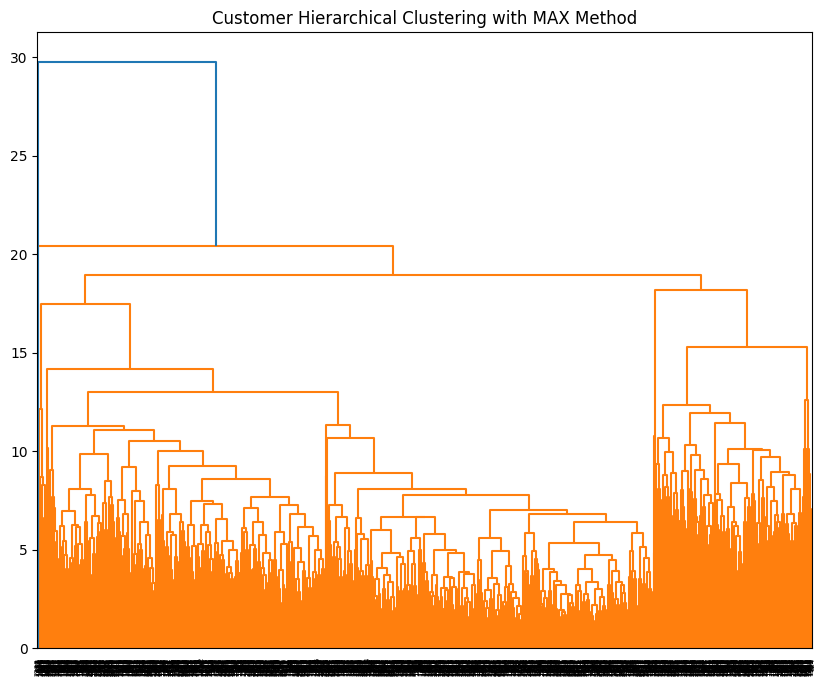

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Customer Hierarchical Clustering with MAX Method")
dend = sch.dendrogram(sch.linkage(df_scaled, method='complete'))
plt.show()

Average Linkage

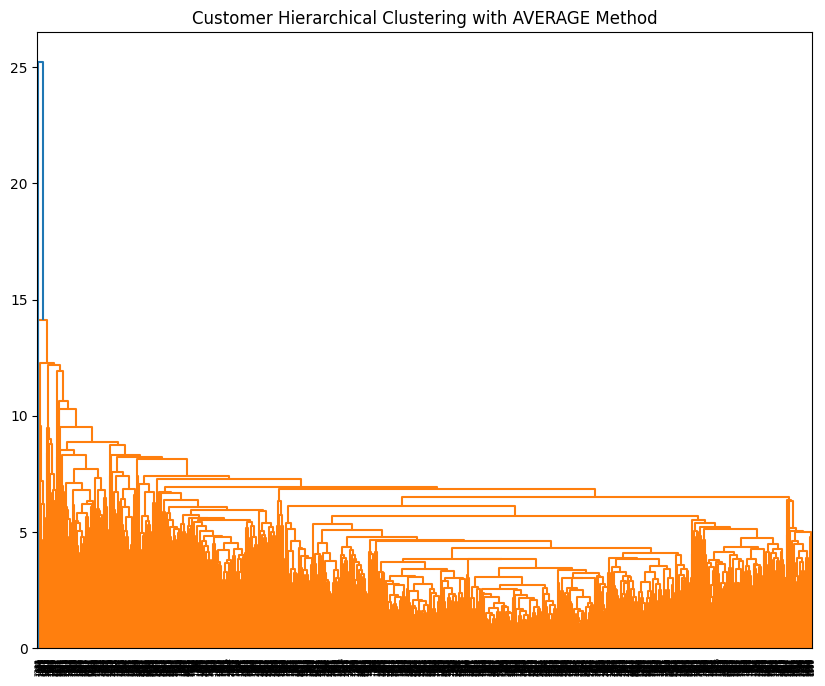

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Customer Hierarchical Clustering with AVERAGE Method")
dend = sch.dendrogram(sch.linkage(df_scaled, method='average'))
plt.show()

Ward Method

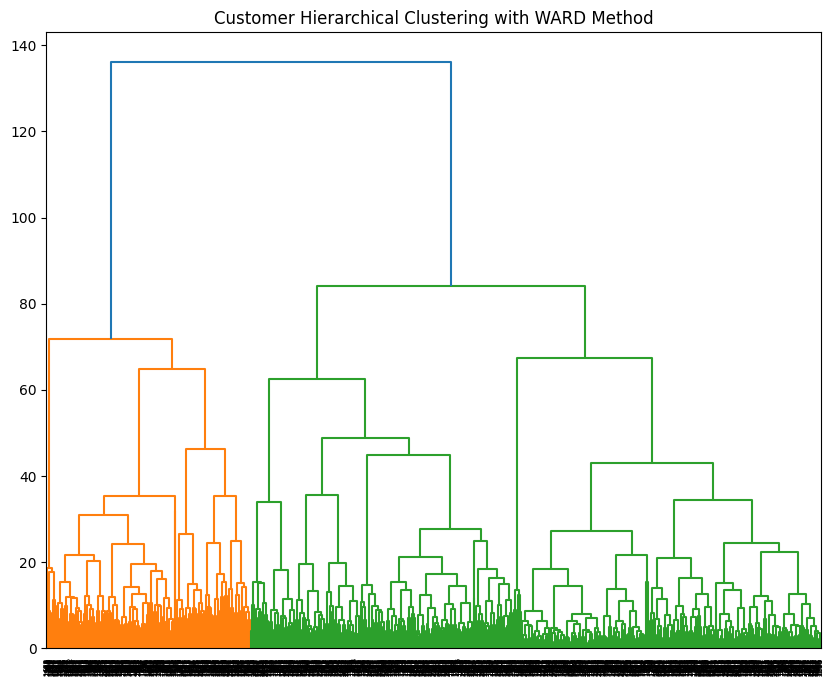

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Customer Hierarchical Clustering with WARD Method")
dend = sch.dendrogram(sch.linkage(df_scaled, method='ward'))
plt.show()